# Data Science & Business Analytics Internship

GRIP: The Sparks Foundation

Author - Dwisha Mehta

Task 1 - Stock Market Prediction using Numerical and Textual Analysis

In this task, I created a time series model using LSTM for TESLA stock performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

Datasets Used:

Historical stock prices :https://finance.yahoo.com/ (Tesla)

Textual news headlines : https://bit.ly/36fFPI6

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-price/TSLA (1).csv
/kaggle/input/stocknews/upload_DJIA_table.csv
/kaggle/input/stocknews/Combined_News_DJIA.csv
/kaggle/input/stocknews/RedditNews.csv
/kaggle/input/india-headlines-news-dataset/india-news-headlines.csv


In [2]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 937.9 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Import Libraries

In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
from textblob import TextBlob
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import seaborn as sns

In [15]:
# reading the data
stock_headlines = pd.read_csv('/kaggle/input/india-headlines-news-dataset/india-news-headlines.csv')
stock_price = pd.read_csv('/kaggle/input/tesla-stock-price/TSLA (1).csv')

In [16]:
# filtering the stock_price data
stock_price = stock_price[stock_price['Date'] > '2020-12-31']

Data Cleaning

In [17]:
# Drop missing values
stock_price.isna().sum() # there are no missing values

# Drop duplicates
stock_price = stock_price.drop_duplicates()
stock_headlines = stock_headlines.drop_duplicates()

# Convert object column to the date column 
stock_price['Date'] = pd.to_datetime(stock_price['Date'], format = '%Y-%m-%d')

# filter out the important columns in the dataset
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# sort the data in ascending order
stock_price.sort_index(ascending = True, axis = 0)

# set the Date column to the index column
stock_price.set_index('Date', inplace=True)

Text(0.5, 1.0, 'Tesla stock attributes from 2020 to 2023')

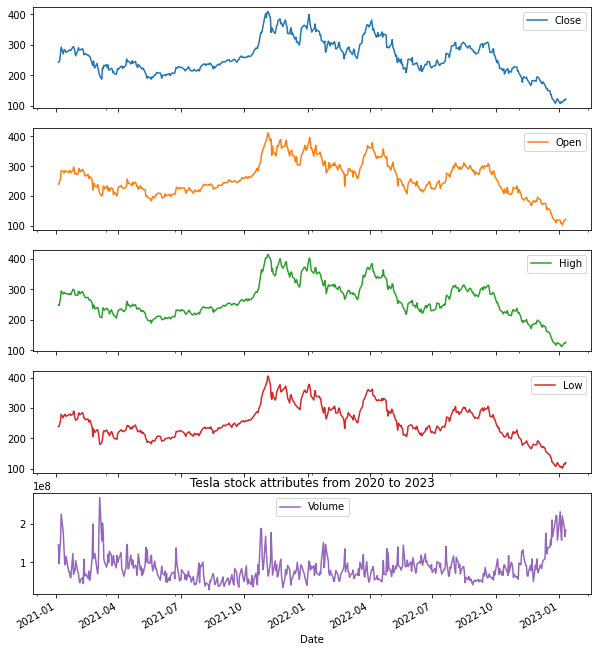

In [18]:
stock_price['2021':'2023'].plot(subplots=True, figsize=(10,12))
plt.title('Tesla stock attributes from 2020 to 2023')

In [19]:
stock_headlines

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
3650965,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


Data Cleaning

In [20]:
# Drop missing values
stock_headlines.isna().sum() # there are no missing values

# Drop duplicates
stock_headlines = stock_headlines.drop_duplicates()

# convert the column to date column
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date'].astype(str), format='%Y%m%d')

In [21]:
# renaming columns
stock_headlines.rename(columns = {'headline_text':'Headlines'}, inplace = True)
stock_headlines.rename(columns = {'publish_date':'Date'}, inplace = True)
# filter out the important columns in the dataset
stock_headlines = stock_headlines.filter(['Date', 'Headlines'])

# set the Date column to the index column
stock_headlines.set_index('Date', inplace=True)

In [22]:
#grouping the data by date column
stock_headlines = stock_headlines.groupby(['Date'])['Headlines'].apply(lambda x:' '.join(x))

Combining both the datasets

In [23]:
stock_data = pd.merge(stock_price, stock_headlines, left_index=True, right_index=True)

In [24]:
stock_data

,Close,Open,High,Low,Volume,Headlines
Date,,,,,,
2021-01-04,243.256668,239.820007,248.163330,239.063339,145914600,Micro review: 'Ahalya's Awakening' by Kavita K...
2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600,Numerology Readings 05 January 2021: Predictio...
2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000,Will UP go for pro-tem chairmanin legislative ...
2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700,Chasing the winter sun in Abu Dhabi Know why s...
2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500,Infra push can help boost consumption CM Yogi ...
...,...,...,...,...,...,...
2022-03-25,336.880005,336.000000,340.600006,332.440002,62031600,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,363.946655,355.033325,365.959991,351.200012,102506100,As fashion becomes democratic; demand for styl...
2022-03-29,366.523346,369.329987,371.589996,357.703339,73614900,Bobby Deol: Like my dad; I hope to be working ...


NLP: Removing Punctuations

In [25]:
import string
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
stock_data['Headlines_wo_punc']=stock_data['Headlines'].apply(lambda x: remove_punctuation(x))

Convert to lower_case and remove extra spacing

In [26]:
stock_data['Headlines_wo_punc'] = stock_data['Headlines_wo_punc'].apply(str.lower)
stock_data['Headlines_wo_punc'] = stock_data['Headlines_wo_punc'].replace(r'\s+', ' ', regex=True)


In [27]:
stopword = nltk.corpus.stopwords.words('english')
print(stopword[:11])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


NLP: Removing Stopwords

In [28]:
def remove_stopwords(text):
    text = nltk.word_tokenize(text)
    text=[word for word in text if word not in stopword]
    return text
stock_data['Headlines_wo_punc_stopwords']=stock_data['Headlines_wo_punc'].apply(lambda x: remove_stopwords(x))



NLP: Lemmatizing

In [29]:
import nltk

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(text) for text in tokens]
    return ' '.join(lemmatized_tokens)

stock_data['Headlines_wo_punc_stopwords_lemmatized']=stock_data['Headlines_wo_punc_stopwords'].apply(lemmatize_text)

Remove irrelevant features

In [30]:
stock_data = stock_data.filter(['Close', 'Open', 'High', 'Low', 'Headlines_wo_punc_stopwords_lemmatized'])

In [31]:
stock_data.rename(columns = {'Headlines_wo_punc_stopwords_lemmatized':'headlines'}, inplace = True)

Removing numerical values from the news headlines

In [32]:
stock_data['headlines'] = stock_data['headlines'].str.replace('\d+','None')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Sentiment Analysis on News Headlines

In [33]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [34]:
stock_data['Subjectivity'] = stock_data['headlines'].apply(getSubjectivity)
stock_data['Polarity'] = stock_data['headlines'].apply(getPolarity)
stock_data
     

,Close,Open,High,Low,headlines,Subjectivity,Polarity
Date,,,,,,,
2021-01-04,243.256668,239.820007,248.163330,239.063339,micro review ahalyas awakening kavita kane hor...,0.396072,0.025513
2021-01-05,245.036667,241.220001,246.946671,239.733337,numerology reading None january None predictio...,0.424583,0.044320
2021-01-06,251.993332,252.830002,258.000000,249.699997,go protem chairmanin legislative council till ...,0.380731,0.040673
2021-01-07,272.013336,259.209991,272.329987,258.399994,chasing winter sun abu dhabi know scheduling s...,0.383995,0.029987
2021-01-08,293.339996,285.333344,294.829987,279.463318,infra push help boost consumption cm yogi adit...,0.387548,0.028130
...,...,...,...,...,...,...,...
2022-03-25,336.880005,336.000000,340.600006,332.440002,speeding shortcut tackling unruly customer tak...,0.361027,-0.031576
2022-03-28,363.946655,355.033325,365.959991,351.200012,fashion becomes democratic demand stylist soar...,0.381832,0.045706
2022-03-29,366.523346,369.329987,371.589996,357.703339,bobby deol like dad hope working age yashas su...,0.393464,0.087860


In [36]:
sia = SentimentIntensityAnalyzer()

stock_data['Compound'] = [sia.polarity_scores(v)['compound'] for v in stock_data['headlines']]

In [37]:
stock_data['Negative'] = [sia.polarity_scores(v)['neg'] for v in stock_data['headlines']]

In [38]:
stock_data['Neutral'] = [sia.polarity_scores(v)['neu'] for v in stock_data['headlines']]


In [39]:
stock_data['Positive'] = [sia.polarity_scores(v)['pos'] for v in stock_data['headlines']]
stock_data

,Close,Open,High,Low,headlines,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
Date,,,,,,,,,,,
2021-01-04,243.256668,239.820007,248.163330,239.063339,micro review ahalyas awakening kavita kane hor...,0.396072,0.025513,-0.9996,0.149,0.747,0.104
2021-01-05,245.036667,241.220001,246.946671,239.733337,numerology reading None january None predictio...,0.424583,0.044320,-0.9987,0.135,0.752,0.113
2021-01-06,251.993332,252.830002,258.000000,249.699997,go protem chairmanin legislative council till ...,0.380731,0.040673,-0.9996,0.144,0.754,0.102
2021-01-07,272.013336,259.209991,272.329987,258.399994,chasing winter sun abu dhabi know scheduling s...,0.383995,0.029987,-0.9996,0.139,0.768,0.093
2021-01-08,293.339996,285.333344,294.829987,279.463318,infra push help boost consumption cm yogi adit...,0.387548,0.028130,-0.9999,0.180,0.736,0.084
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,336.880005,336.000000,340.600006,332.440002,speeding shortcut tackling unruly customer tak...,0.361027,-0.031576,-0.9998,0.155,0.750,0.095
2022-03-28,363.946655,355.033325,365.959991,351.200012,fashion becomes democratic demand stylist soar...,0.381832,0.045706,-0.9994,0.144,0.742,0.114
2022-03-29,366.523346,369.329987,371.589996,357.703339,bobby deol like dad hope working age yashas su...,0.393464,0.087860,-0.9996,0.136,0.774,0.091


Exploratory Data Analysis

In [42]:
stock_data.describe()

,Close,Open,High,Low,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,270.160849,270.190212,276.136369,263.798609,0.372615,0.039259,-0.970619,0.142860,0.755713,0.101455
std,54.495569,54.539239,56.283281,52.550442,0.020548,0.021955,0.229965,0.011625,0.012596,0.009862
min,187.666672,184.183334,188.736664,179.830002,0.308582,-0.031576,-0.999900,0.097000,0.721000,0.078000
25%,226.054997,227.331665,231.581665,222.668327,0.359251,0.025372,-0.999700,0.135000,0.747000,0.096000
50%,258.450012,258.578338,263.771668,252.855003,0.373917,0.036927,-0.999600,0.143000,0.755000,0.101000
75%,306.823341,304.206680,312.074157,297.591667,0.386657,0.050095,-0.999300,0.151000,0.764000,0.107000
max,409.970001,411.470001,414.496674,405.666656,0.436169,0.125060,0.999500,0.180000,0.788000,0.141000


<AxesSubplot:>

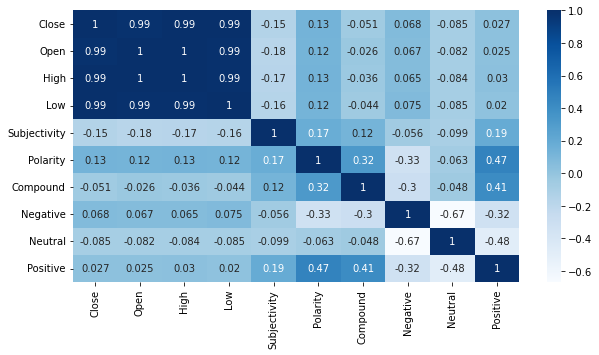

In [45]:
plt.figure(figsize=(10,5))
sns.heatmap(stock_data.corr(),cmap='Blues',annot=True)

<AxesSubplot:>

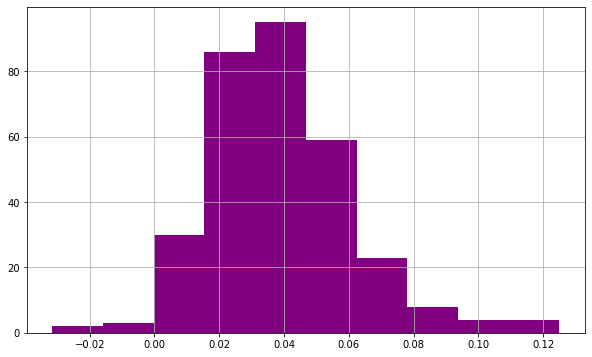

In [40]:
plt.figure(figsize = (10,6))
stock_data['Polarity'].hist(color = 'purple')

<AxesSubplot:>

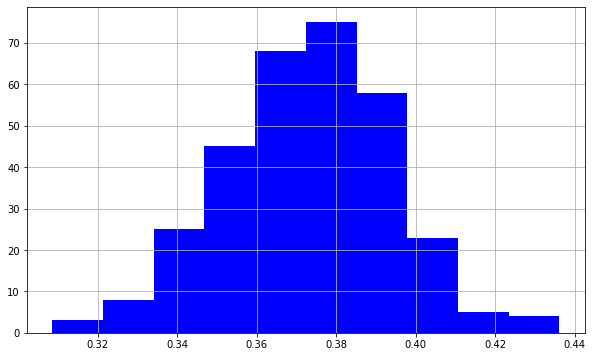

In [41]:
plt.figure(figsize = (10,6))
stock_data['Subjectivity'].hist(color = 'blue')

Text(0, 0.5, 'Close Price')

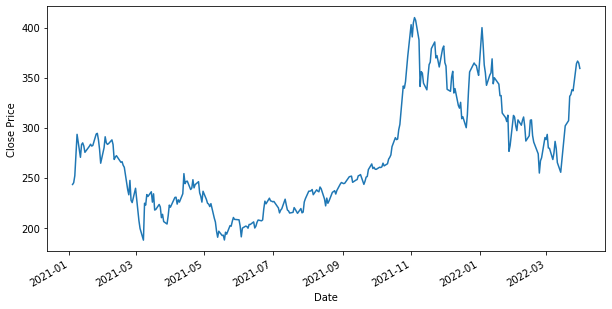

In [48]:
plt.figure(figsize=(10,5))
stock_data['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Close Price')

<AxesSubplot:xlabel='Date'>

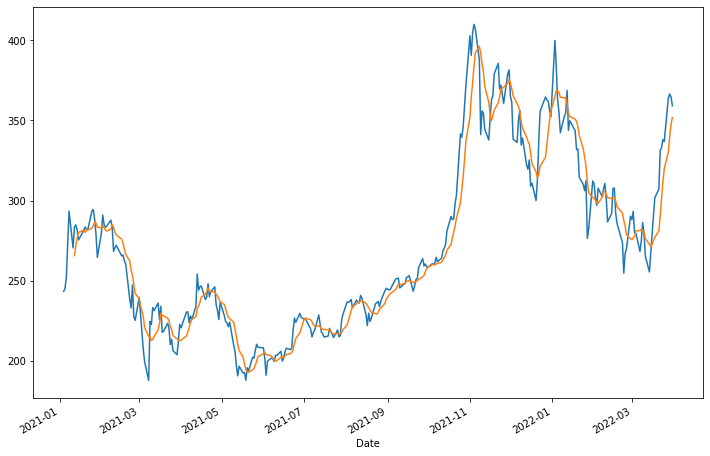

In [49]:
plt.figure(figsize=(12,8))
stock_data[stock_data.index > '2014-01-01']['Close'].plot()
stock_data[stock_data.index > '2014-01-01'].rolling(window=7).mean()['Close'].plot()

<AxesSubplot:xlabel='Date'>

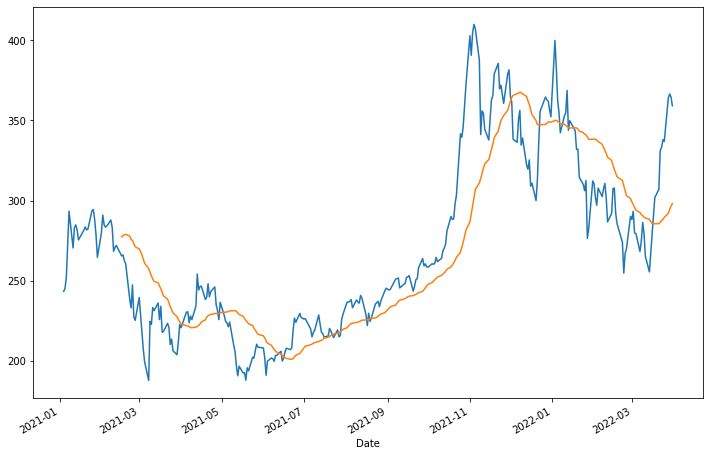

In [50]:
plt.figure(figsize=(12,8))
stock_data[stock_data.index > '2014-01-01']['Close'].plot()
stock_data[stock_data.index > '2014-01-01'].rolling(window=30).mean()['Close'].plot()

In [51]:
stock_data = stock_data.drop(['headlines'], axis = 1)

Data Preparation for Modelling

In [52]:
time_step = 1
training_size = int(len(stock_data) * 0.80)
test_size = len(stock_data) - training_size
train_data, test_data = stock_data.iloc[0:training_size, :], stock_data.iloc[training_size - time_step:len(stock_data), :]

In [53]:
def create_dataset(data, time_step = 1):
    features = [data["Close"]]
    feature_names = ["Close"]
    for i in range(1, time_step + 1):
        feature = "cp_shifted_{k}".format(k = i)
        feature_names.append(feature)
        temp = data["Close"].shift((-1 * i))
        features.append(temp);
        
    features.append(data["Compound"]) 
    feature_names.append("Compound")
    for i in range(1, time_step + 1):
        feature = "compound_shifted_{k}".format(k = i)
        feature_names.append(feature)
        temp = data["Compound"].shift((-1 * i))
        features.append(temp);
    
    
    df = pd.concat(features, axis=1)
    df.columns = feature_names
    df = df.shift(periods = time_step)
    df = df.dropna()
    return df

In [54]:
X_train = create_dataset(train_data, time_step)
X_test = create_dataset(test_data, time_step)

In [55]:
y_train = X_train["cp_shifted_{t}".format(t = time_step)]
y_test = X_test["cp_shifted_{t}".format(t = time_step)]


In [56]:
X_train.drop(columns = ["cp_shifted_{t}".format(t = time_step)], inplace = True)
X_test.drop(columns = ["cp_shifted_{t}".format(t = time_step)], inplace = True)

In [57]:
X_train.shape, X_test.shape

((250, 3), (63, 3))

Scaling the target variable and feature dataset

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

X_train = scaler.fit_transform(np.array(X_train))
y_train = scaler.fit_transform(np.array(y_train).reshape((len(y_train), 1)))

X_test = scaler.fit_transform(np.array(X_test))
y_test = scaler.fit_transform(np.array(y_test).reshape((len(y_test), 1)))

In [59]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((250, 3), (250, 1), (63, 3), (63, 1))

Dividing dataset into training and testing

In [60]:
# Reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# Printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (250, 3, 1)
Shape of Test set X: (63, 3, 1)


Modelling Stock Data

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation

In [62]:
# Creating the model architecture
model=Sequential()
model.add(LSTM(60,return_sequences=True,activation='tanh',input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(120,return_sequences=True,activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(240,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# Printing the model summary
model.summary()

2023-01-13 20:39:16.840771: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 60)             14880     
_________________________________________________________________
dropout (Dropout)            (None, 3, 60)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 120)            86880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 120)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 240)               346560    
_________________________________________________________________
dropout_2 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [63]:
# Compiling the model
model.compile(loss='mse' , optimizer='adam')

# Fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=16, verbose=1)

2023-01-13 20:39:27.824935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
13/13 [==============================] - 7s 114ms/step - loss: 0.0308 - val_loss: 0.1327
Epoch 2/25
13/13 [==============================] - 0s 17ms/step - loss: 0.0141 - val_loss: 0.2605
Epoch 3/25
13/13 [==============================] - 0s 16ms/step - loss: 0.0108 - val_loss: 0.1513
Epoch 4/25
13/13 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0756
Epoch 5/25
13/13 [==============================] - 0s 16ms/step - loss: 0.0059 - val_loss: 0.0371
Epoch 6/25
13/13 [==============================] - 0s 16ms/step - loss: 0.0052 - val_loss: 0.0449
Epoch 7/25
13/13 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0244
Epoch 8/25
13/13 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0278
Epoch 9/25
13/13 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0262
Epoch 10/25
13/13 [==============================] - 0s 16ms/step - loss: 0.0030 - val_loss: 0.0178
Epoch 11

Predictions

In [64]:
predictions = model.predict(X_test) 

# Unscaling the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# Printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[334.93304],
       [332.91647],
       [349.85867],
       [344.903  ],
       [337.4301 ]], dtype=float32)

In [65]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [66]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [68]:
import math

In [69]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

298.4557234327765

In [70]:
math.sqrt(mean_squared_error(y_test,test_predict))

306.54176563430235

Model evaluation

In [71]:
# Calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# Calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# Printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

63/63 [==============================] - 0s 3ms/step - loss: 0.0151
Train Loss = 0.0094
Test Loss = 0.0151


In [72]:
from sklearn import metrics

In [73]:
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 306.5418


In [74]:
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 306.5418


Plotting the predictions against unseen data

In [75]:
X_test = scaler.inverse_transform(np.array(X_test).reshape((len(X_test), 3)))

# Unscaling y_test, y_train
y_train = scaler.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

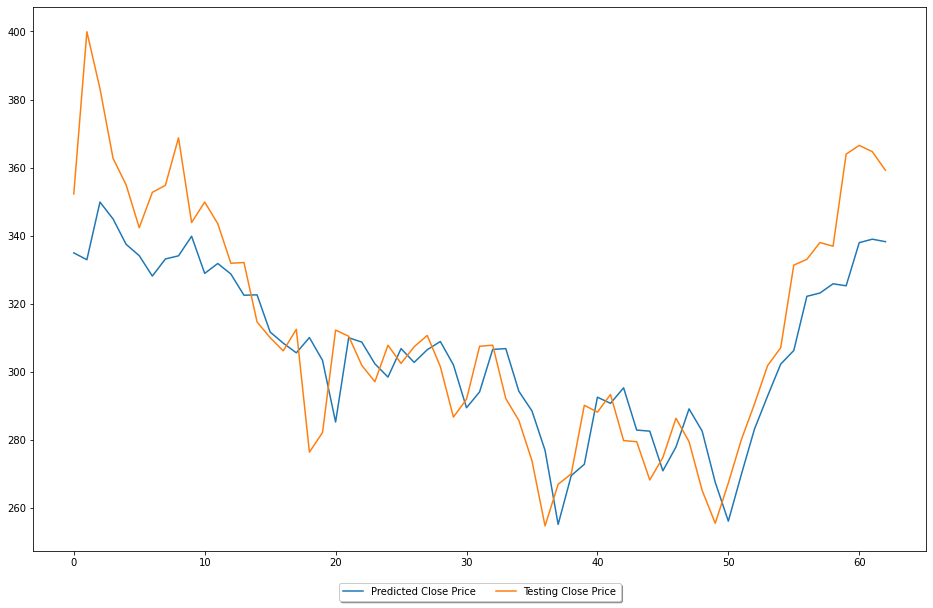

In [76]:
# Plotting
plt.figure(figsize=(16,10))

plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()